In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install torch_snippets torch_summary

In [277]:
import os
import time
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from tempfile import TemporaryDirectory
import torchvision

In [278]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [321]:
DIR = "../input/human-action-recognition-har-dataset/Human Action Recognition/"
TRAIN_DIR = f"{DIR}train"
TRAIN_VAL_DF = "../input/human-action-recognition-har-dataset/Human Action Recognition/Training_set.csv"

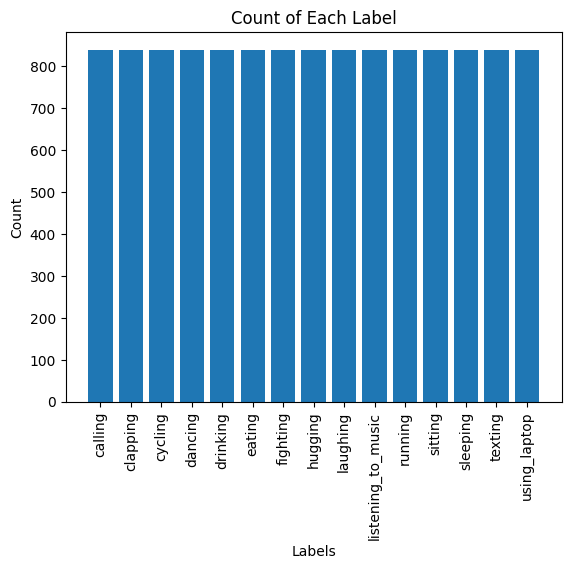

In [322]:
df = pd.read_csv(TRAIN_VAL_DF)
agg_labels = df.groupby('label').agg({'label': 'count'}).rename(columns={'label': 'count'})
plt.bar(agg_labels.index, agg_labels['count'])
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Count of Each Label')
plt.xticks(rotation=90)
plt.show()

In [379]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [380]:
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.annotations = self.annotations[self.annotations['filename'].apply(
            lambda x: os.path.isfile(os.path.join(self.root_dir,x)))]
        
        print(f"Images found: {len(self.annotations)}")

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = self.annotations.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
            
        return image, label, img_name 

In [381]:
train_dataset = CustomImageDataset(csv_file=TRAIN_VAL_DF, root_dir=TRAIN_DIR, transform=data_transforms['train'])
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)

print(df['label'].unique())

Images found: 12600
['sitting' 'using_laptop' 'hugging' 'sleeping' 'drinking' 'clapping'
 'dancing' 'cycling' 'calling' 'laughing' 'eating' 'fighting'
 'listening_to_music' 'running' 'texting']


In [382]:
class_names = {}
for i, class_name in enumerate(df['label'].unique()):
    class_names[i] = class_name

In [383]:
def imshow(inp, title):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    plt.title(title, fontsize=14)
    plt.axis('off')

../input/human-action-recognition-har-dataset/Human Action Recognition/train/Image_2371.jpg
../input/human-action-recognition-har-dataset/Human Action Recognition/train/Image_9759.jpg
../input/human-action-recognition-har-dataset/Human Action Recognition/train/Image_10043.jpg
../input/human-action-recognition-har-dataset/Human Action Recognition/train/Image_7314.jpg


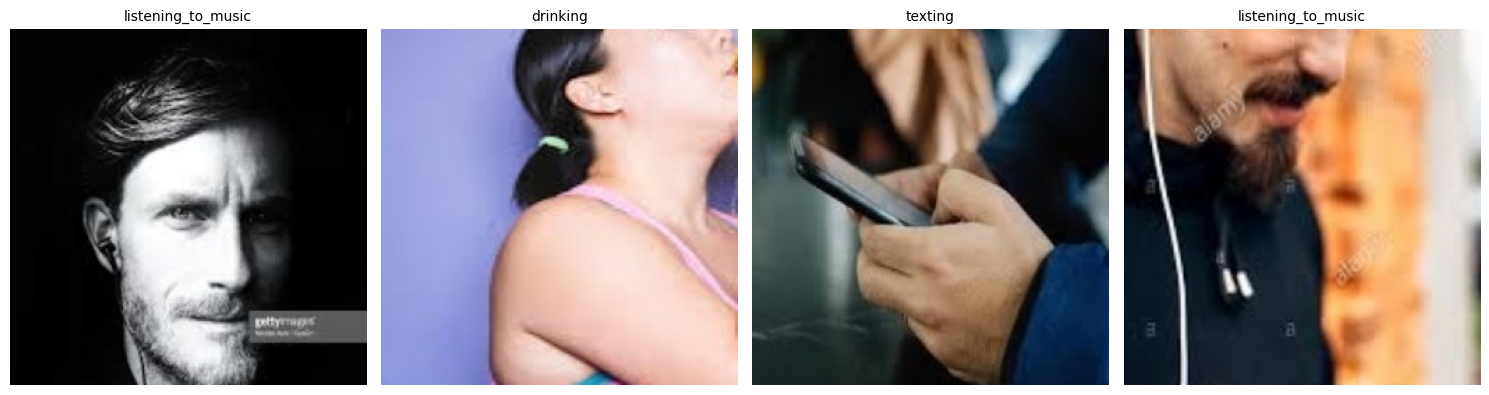

In [384]:
inputs, classes, paths = next(iter(train_loader))

num_images = inputs.size(0)

for path in paths:
    print(path)

fig, axes = plt.subplots(1, num_images, figsize=(15, 5)) 

titles = [f"{x}" for x in classes]  # Combine class and path

for ax, img, title in zip(axes, inputs, titles):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    ax.imshow(img)
    ax.set_title(title, fontsize=10)  # Reduced fontsize for better visibility
    ax.axis('off')  # Hide axes

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [385]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        best_acc = 0.0
        for epoch in range(num_epochs):
            print(f"Epoch {epoch}")
            print('-' * 15)
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()
                
                running_loss = 0.0
                running_corrects = 0
                
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                if phase == 'train':
                    scheduler.step()
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print(f"{phase} | loss : {epoch_loss} | acc : {epoch_acc:.4f}")
                
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
        
        print()
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(torch.load(best_model_params_path))
    return model

In [386]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [387]:
from torch.optim import lr_scheduler
model_ft = models.resnet18(weights = "IMAGENET1K_V1")
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr = 0.001, momentum = 0.6)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma = 0.1)

In [388]:
# model_ft

In [389]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0
---------------


FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_30/1452714004.py", line 18, in __getitem__
    image = Image.open(img_name)
  File "/opt/conda/lib/python3.10/site-packages/PIL/Image.py", line 3431, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/Image_9733.jpg'
